<center><img src="https://raw.githubusercontent.com/openvinotoolkit/anomalib/main/docs/source/images/logos/anomalib-wide-blue.png" alt="Paris" class="center"></center>

<center>💙 A library for benchmarking, developing and deploying deep learning anomaly detection algorithms</center>

______________________________________________________________________

> NOTE:
> This notebook is originally created by @innat on [Kaggle](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/notebook).

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

The library supports [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0) and [`BeanTech`](https://paperswithcode.com/dataset/btad) (CC-BY-SA) for **benchmarking** and `folder` for custom dataset **training/inference**. In this notebook, we will explore `anomalib` training a PADIM model on the `MVTec AD` bottle dataset and evaluating the model's performance. The sections in this notebook explores the steps in `tools/train.py` more in detail. Those who would like to reproduce the results via CLI could use `python tools/train.py --model padim`.

## Installing Anomalib

Installation can be done in two ways: (i) install via PyPI, or (ii) installing from source. In this notebook, we'll install it from the PyPI version for the sake of simplicity.

In [1]:
# %pip install anomalib nncf openvino-dev

## Imports

In [2]:
from pathlib import Path
from typing import Any, Dict

import numpy as np
import torch
from IPython.display import display
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

/home/ubuntu/venvs/anomalib_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/venvs/anomalib_env/lib/python3.8/site-packages/nncf/torch/dynamic_graph/patch_pytorch.py:163: UserWarning: Not patching unique_dim since it is missing in this version of PyTorch
  warnings.warn("Not patching {} since it is missing in this version of PyTorch".format(op_name))


## Model

Currently, there are **7** anomaly detection models available in `anomalib` library. Namely,

- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/main/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using Padim. Now, let's get their config paths from the respected folders.

## Configuration

In this demonstration, we will choose [Padim](https://arxiv.org/pdf/2011.08785.pdf) model from the above list. Let's take a quick look at its config file.

In [3]:
MODEL = "padim"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = f"../../anomalib/models/{MODEL}/config.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: mvtec #options: [mvtec, btech, folder]
  format: mvtec
  path: ./datasets/MVTec
  category: bottle
  task: segmentation
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  num_workers: 8
  transform_config:
    train: null
    val: null
  create_validation_set: false
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: padim
  backbone: resnet18
  pre_trained: true
  layers:
    - layer1
    - layer2
    - layer3
  normalization_method: min_max # options: [none, min_max, cdf]

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC
  threshold:
    method: adaptive #options: [adaptive, manual]
    manual_image: null
    manual_pixel: null

visualization:
  show_images: False # show images on the screen
  save_images: True # save images to the file system
  log_images: True # log images to the available loggers (if any)
  image

We could use [get_configurable_parameter](https://github.com/openvinotoolkit/anomalib/blob/main/anomalib/config/config.py#L114) function to read the configs from the path and return them in a dictionary. We use the default config file that comes with Padim implementation, which uses `./datasets/MVTec` as the path to the dataset. We need to overwrite this after loading the config.

In [4]:
# pass the config file to model, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)
config["dataset"]["path"] = "../../datasets/MVTec"  # or wherever the MVTec dataset is stored.

## Dataset: MVTec AD

**MVTec AD** is a dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains over **5000** high-resolution images divided into **15** different object and texture categories. Each category comprises a set of defect-free training images and a test set of images with various kinds of defects as well as images without defects. If the dataset is not located in the root datasets directory, anomalib will automatically install the dataset.

We could now import the MVtec AD dataset using its specific datamodule implemented in anomalib.

In [5]:
datamodule = get_datamodule(config)
datamodule.setup()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.prepare_data()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
data.keys()

Transform configs has not been provided. Images will be normalized using ImageNet statistics.
Transform configs has not been provided. Images will be normalized using ImageNet statistics.


dict_keys(['image', 'image_path', 'label', 'mask_path', 'mask'])

Let's check the shapes of the input images and masks.

In [6]:
print(data["image"].shape, data["mask"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])


We could now visualize a normal and abnormal sample from the validation set.

/home/ubuntu/repos/anomalib/anomalib/pre_processing/transforms/custom.py:23: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


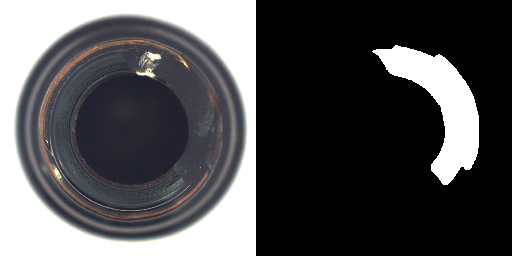

In [7]:
def show_image_and_mask(sample: Dict[str, Any], index: int) -> Image:
    img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
    msk = ToPILImage()(sample["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))


# Visualize a normal image-mask
show_image_and_mask(data, index=0)

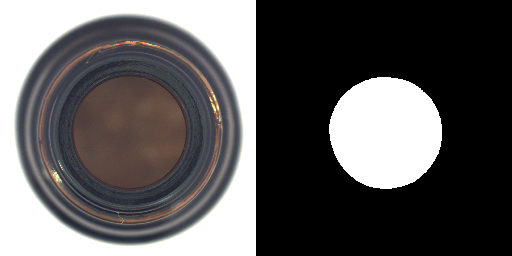

In [8]:
# Visualize an abnormal image-mask
show_image_and_mask(data, index=20)

## Prepare Model and Callbacks

Now, the config file is updated as we want. We can now start model training with it. Here we will be using `datamodule`, `model` and `callbacks` to train the model. Callbacks are self-contained objects, which contains non-essential logic. This way we could inject as many callbacks as possible such as ModelLoading, Timer, Metrics, Normalization and Visualization

In [9]:
model = get_model(config)
callbacks = get_callbacks(config)

/home/ubuntu/venvs/anomalib_env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/ubuntu/repos/anomalib/anomalib/utils/callbacks/__init__.py:143: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")


In [10]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [11]:
from nncf.torch.initialization import PTInitializingDataLoader
from torch.utils.data import DataLoader
from typing import Tuple 

class InitLoader(PTInitializingDataLoader):
    """Initializing data loader for NNCF to be used with unsupervised training algorithms."""

    def __init__(self, data_loader: DataLoader):
        super().__init__(data_loader)
        self._data_loader_iter: Iterator

    def __iter__(self):
        """Create iterator for dataloader."""
        self._data_loader_iter = iter(self._data_loader)
        return self

    def __next__(self) -> Any:
        """Return next item from dataloader iterator."""
        loaded_item = next(self._data_loader_iter)
        return loaded_item["image"]

    def get_inputs(self, dataloader_output) -> Tuple[Tuple, Dict]:
        """Get input to model.
        Returns:
            (dataloader_output,), {}: Tuple[Tuple, Dict]: The current model call to be made during
            the initialization process
        """
        return (dataloader_output,), {}

    def get_target(self, _):
        """Return structure for ground truth in loss criterion based on dataloader output.
        This implementation does not do anything and is a placeholder.
        Returns:
            None
        """
        return None

In [12]:
trainer.fit(model=model, datamodule=datamodule)

/home/ubuntu/venvs/anomalib_env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/ubuntu/venvs/anomalib_env/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/ubuntu/repos/anomalib/notebooks/000_getting_started/results/padim/mvtec/bottle/weights exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/ubuntu/venvs/anomalib_env/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:183: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalySco

Epoch 0:  10%|██████████████▊                                                                                                                                     | 1/10 [00:01<00:11,  1.28s/it, loss=nan, v_num=27]

/home/ubuntu/venvs/anomalib_env/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:137: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Epoch 0:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7/10 [00:03<00:01,  2.15it/s, loss=nan, v_num=27]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.10s/it, loss=nan, v_num=27, pixel_F1Score=0.723, pixel_AUROC=0.982]


## Validation

In [13]:
with torch.no_grad():
    torch.onnx.export(model.model.eval(), data["image"][:1,::], "fp32_model.onnx")

/home/ubuntu/venvs/anomalib_env/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:374: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  warnings.warn("You are trying to export the model with " + onnx_op + " for ONNX opset version "


In [14]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
fp32_metrics = trainer.test(model=model, datamodule=datamodule)

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.42s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9928570985794067
      image_F1Score              0.984375
       pixel_AUROC          0.9824491143226624
      pixel_F1Score         0.7229292988777161
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


By default, the output images are saved into `results` directory. We could get the output filenames from the directory, read the saved the images and visualize here.

In [15]:
print(config["project"]["path"])

results/padim/mvtec/bottle


In [16]:
image_filenames = list(Path(config["project"]["path"]).glob("**/*.png"))
print(image_filenames[0])

results/padim/mvtec/bottle/images/image_ROC.png


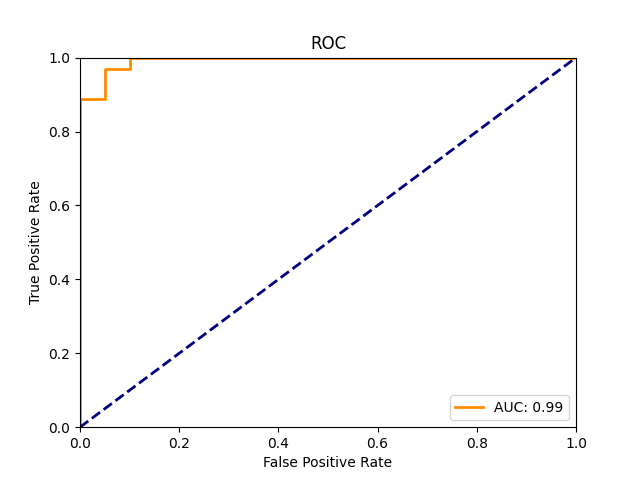

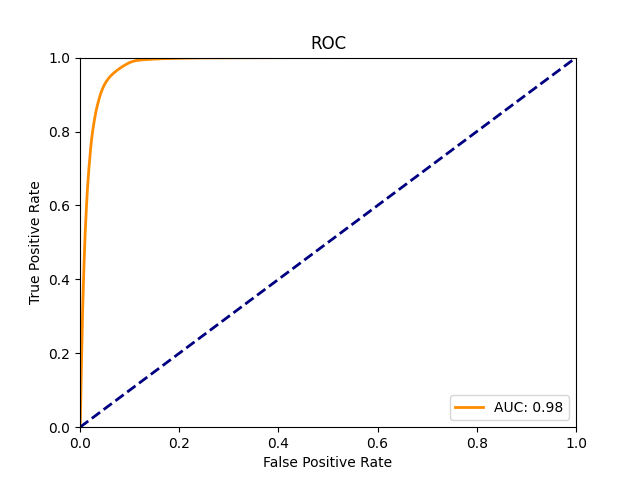

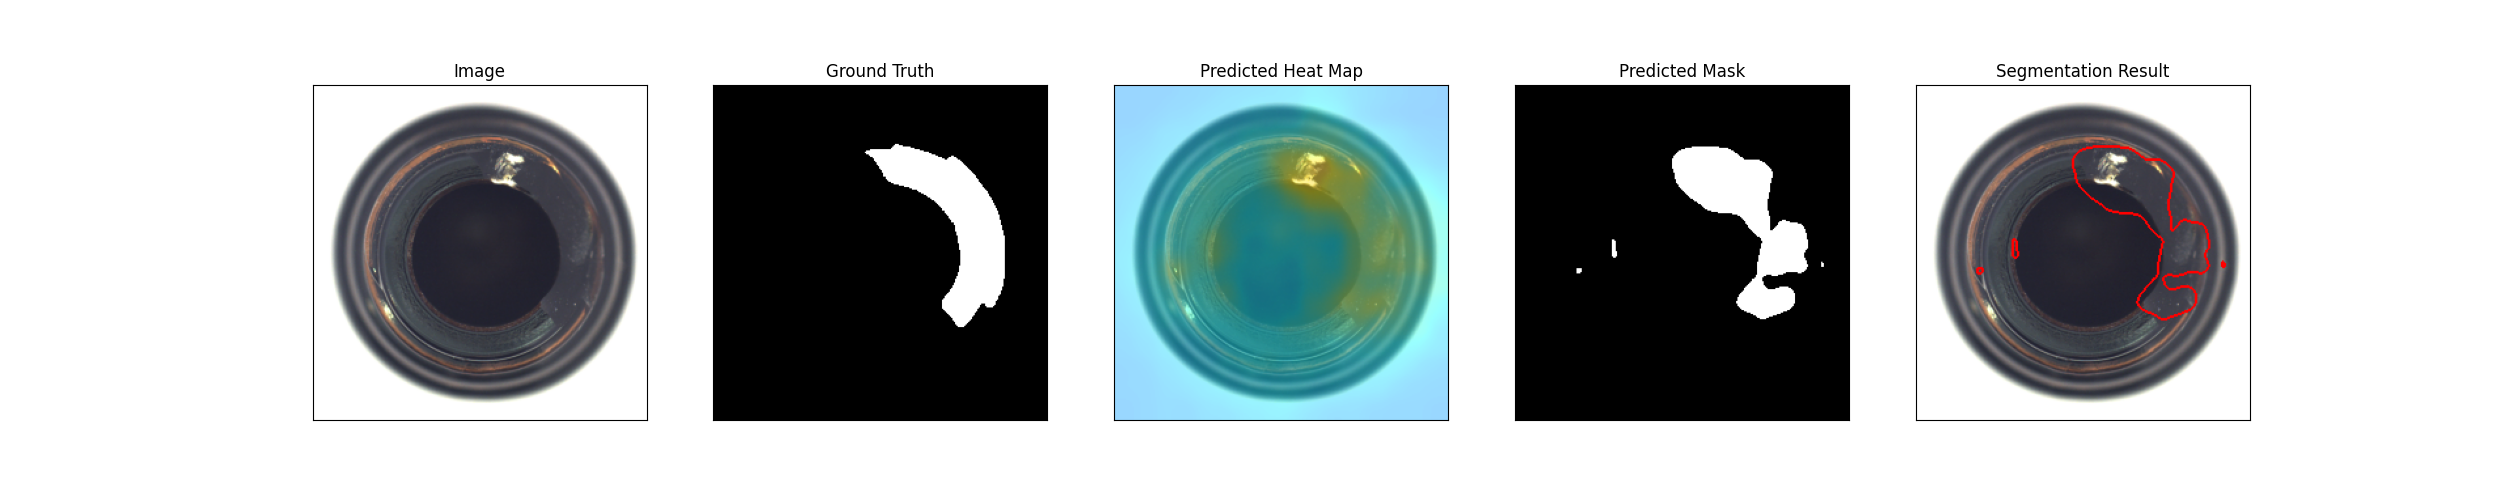

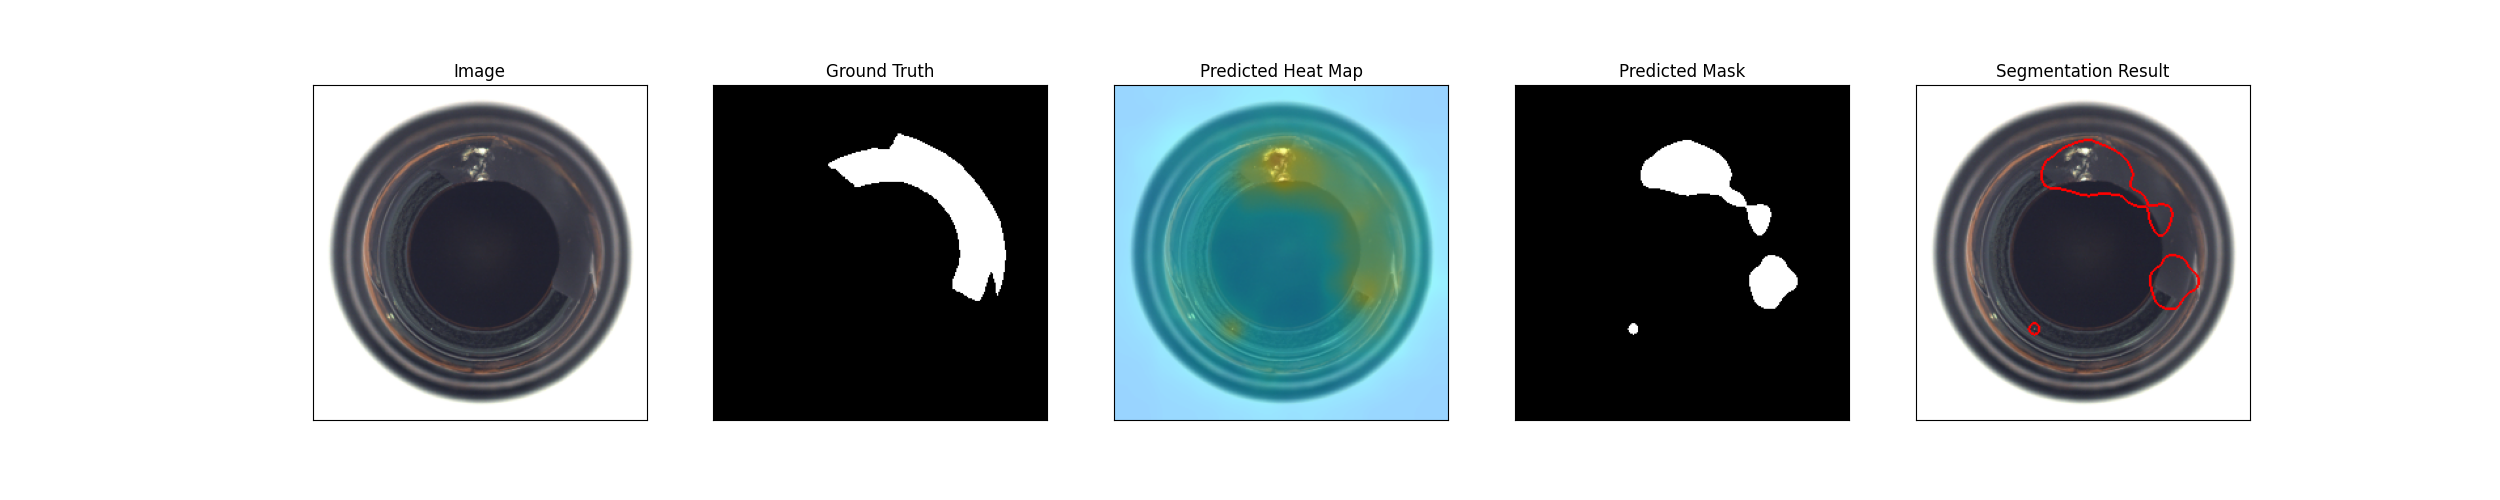

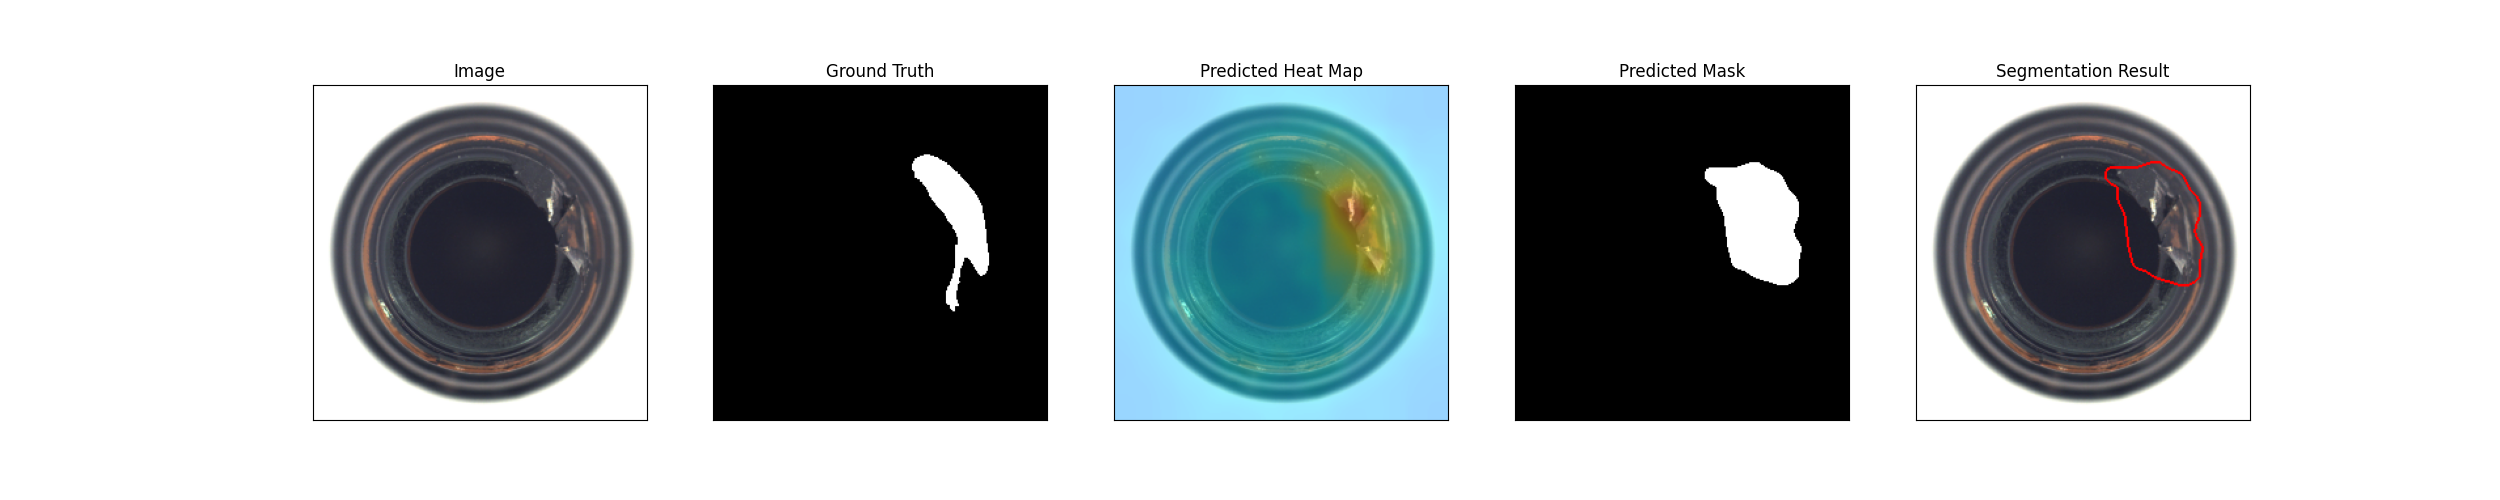

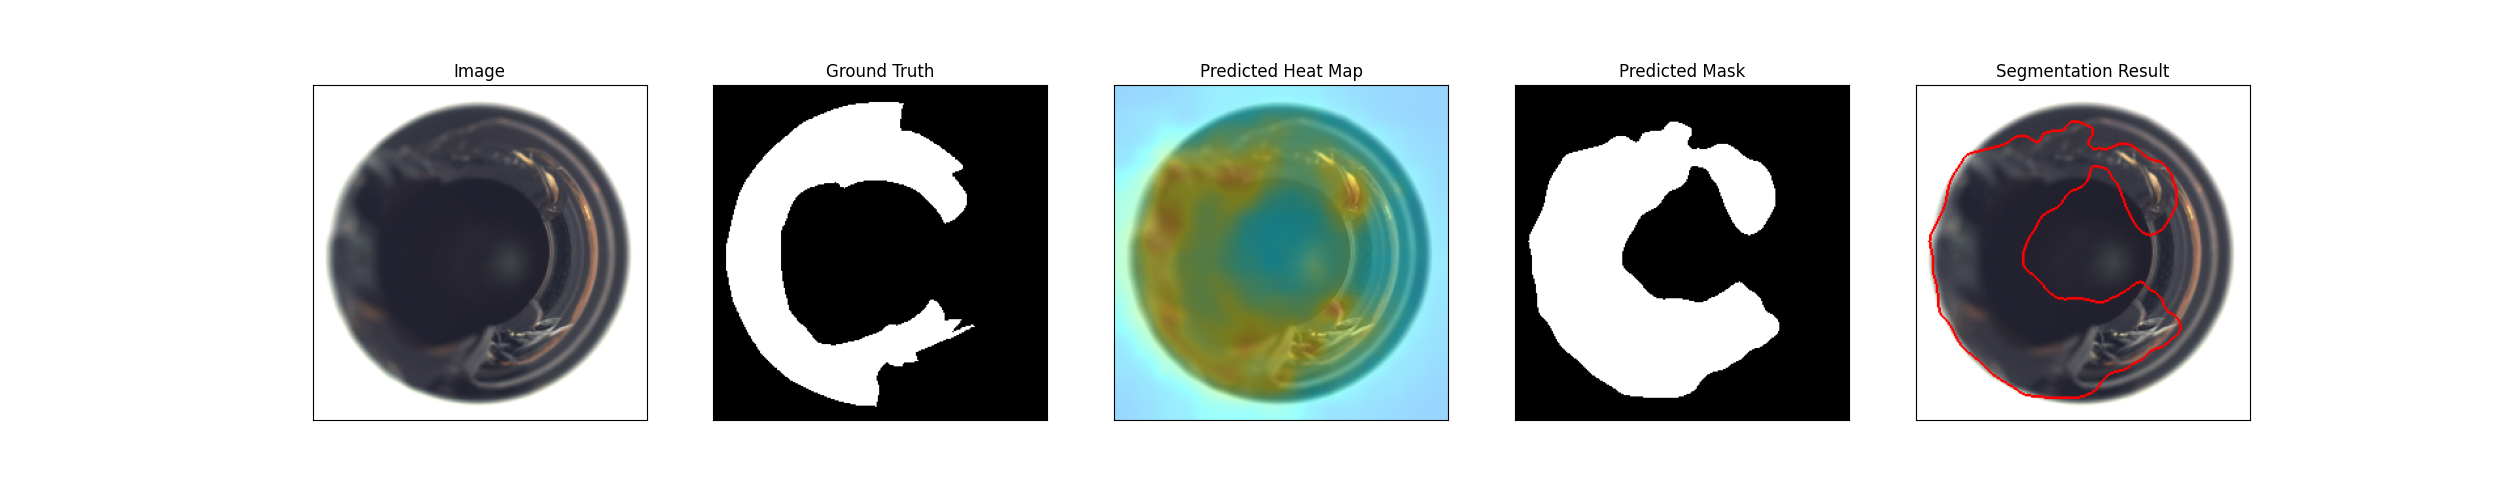

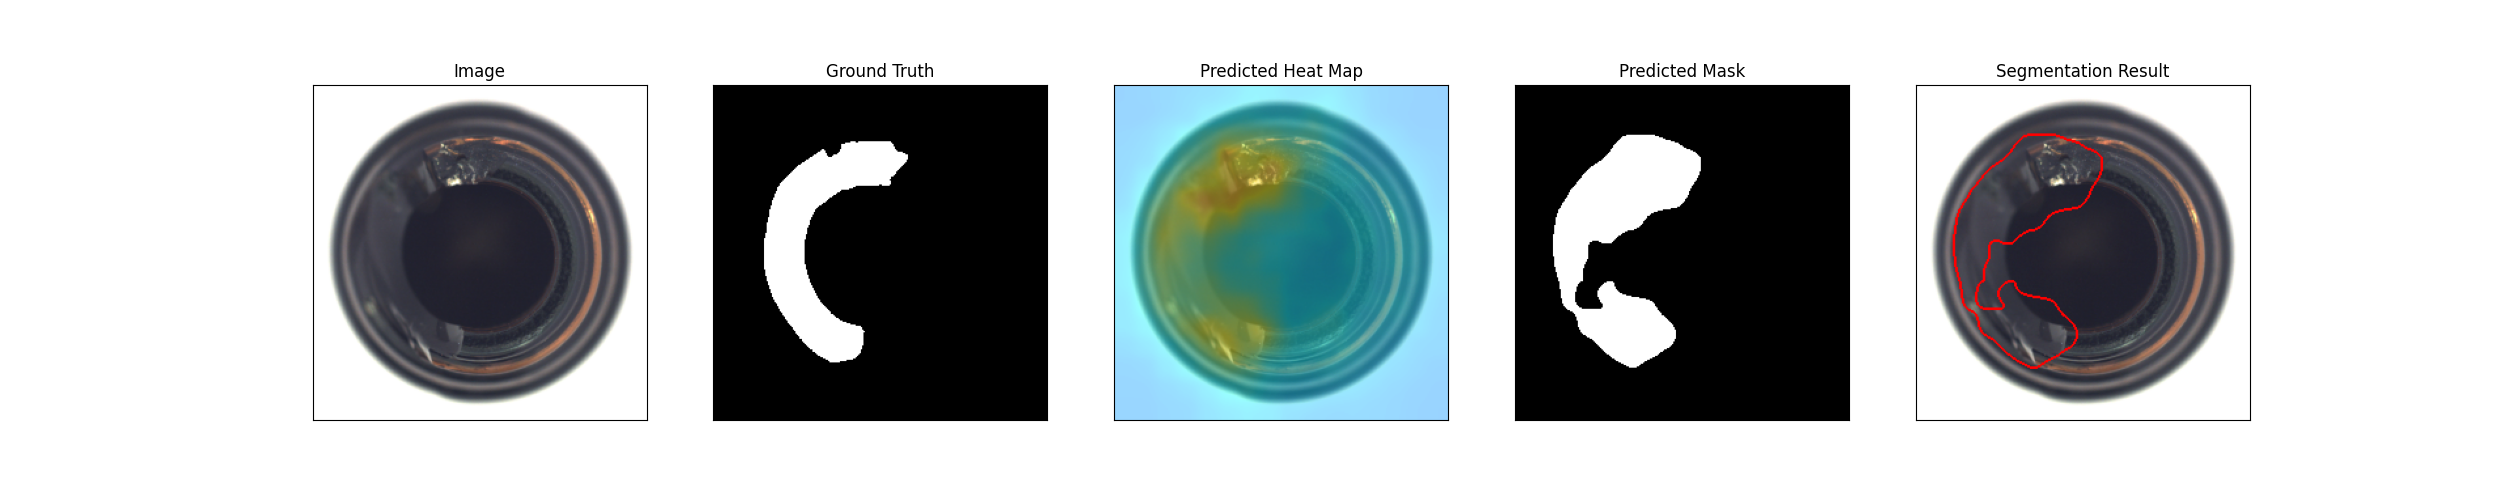

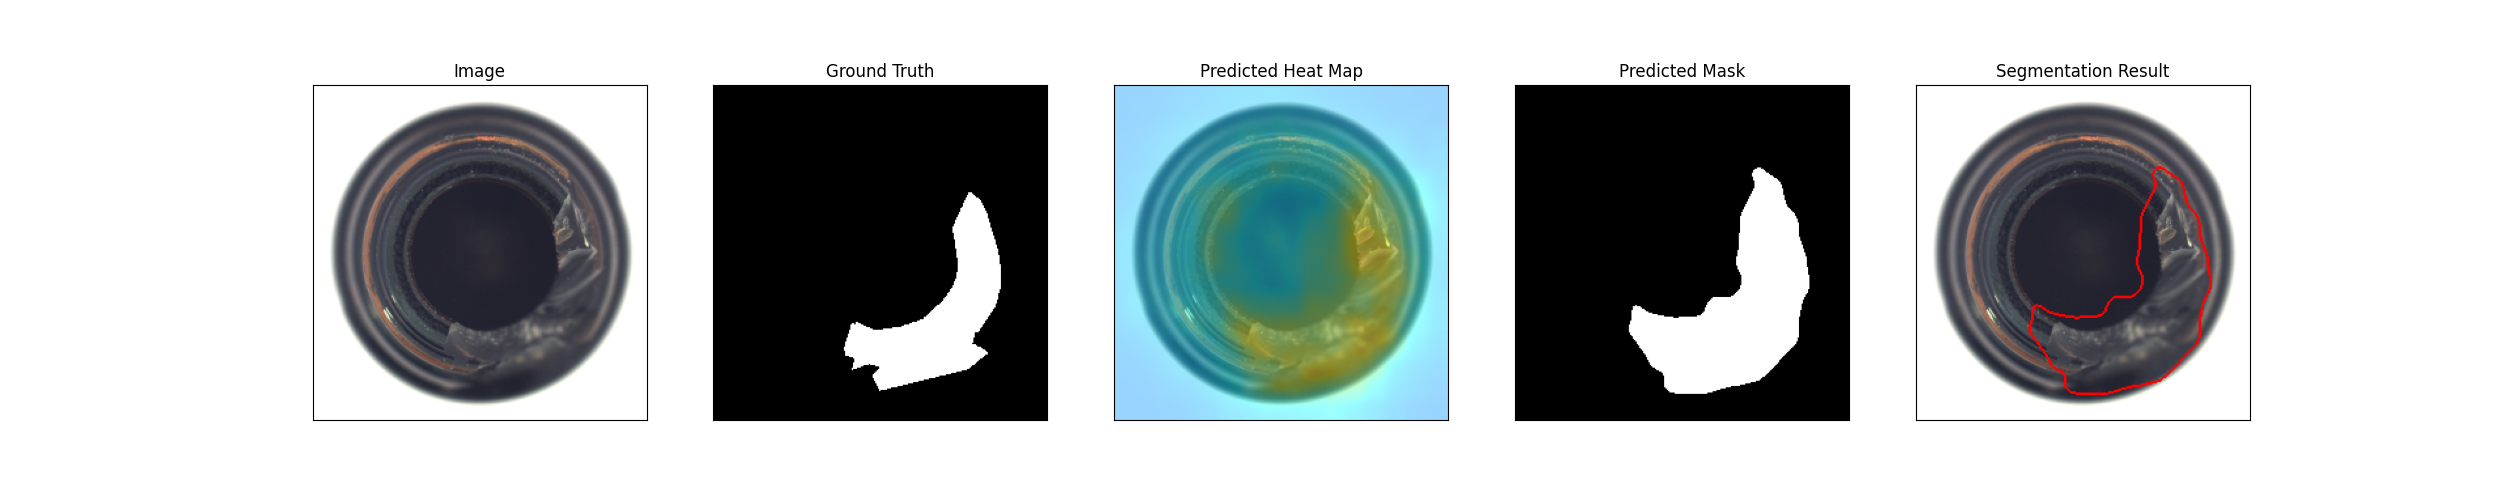

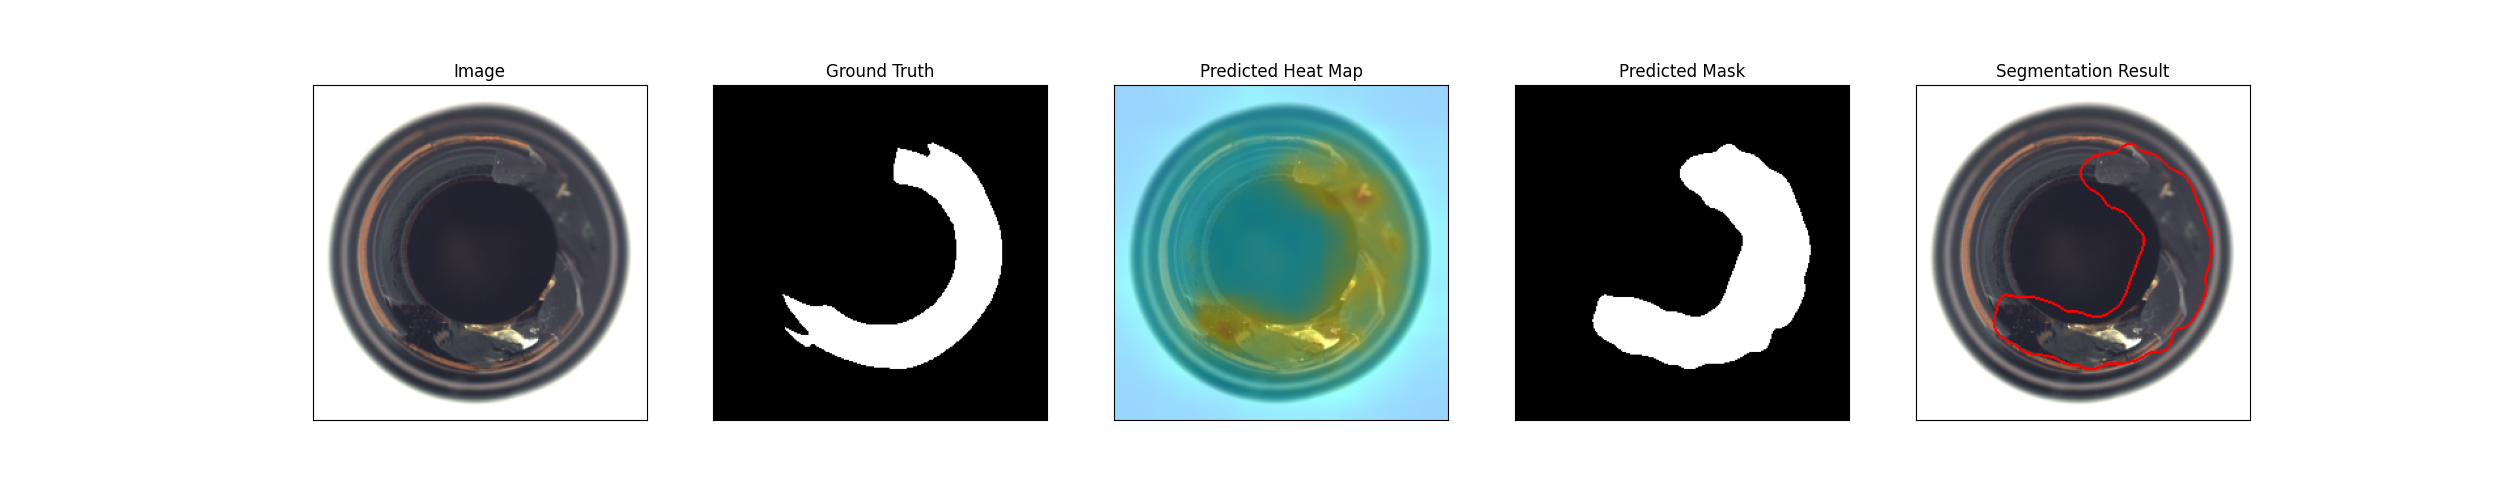

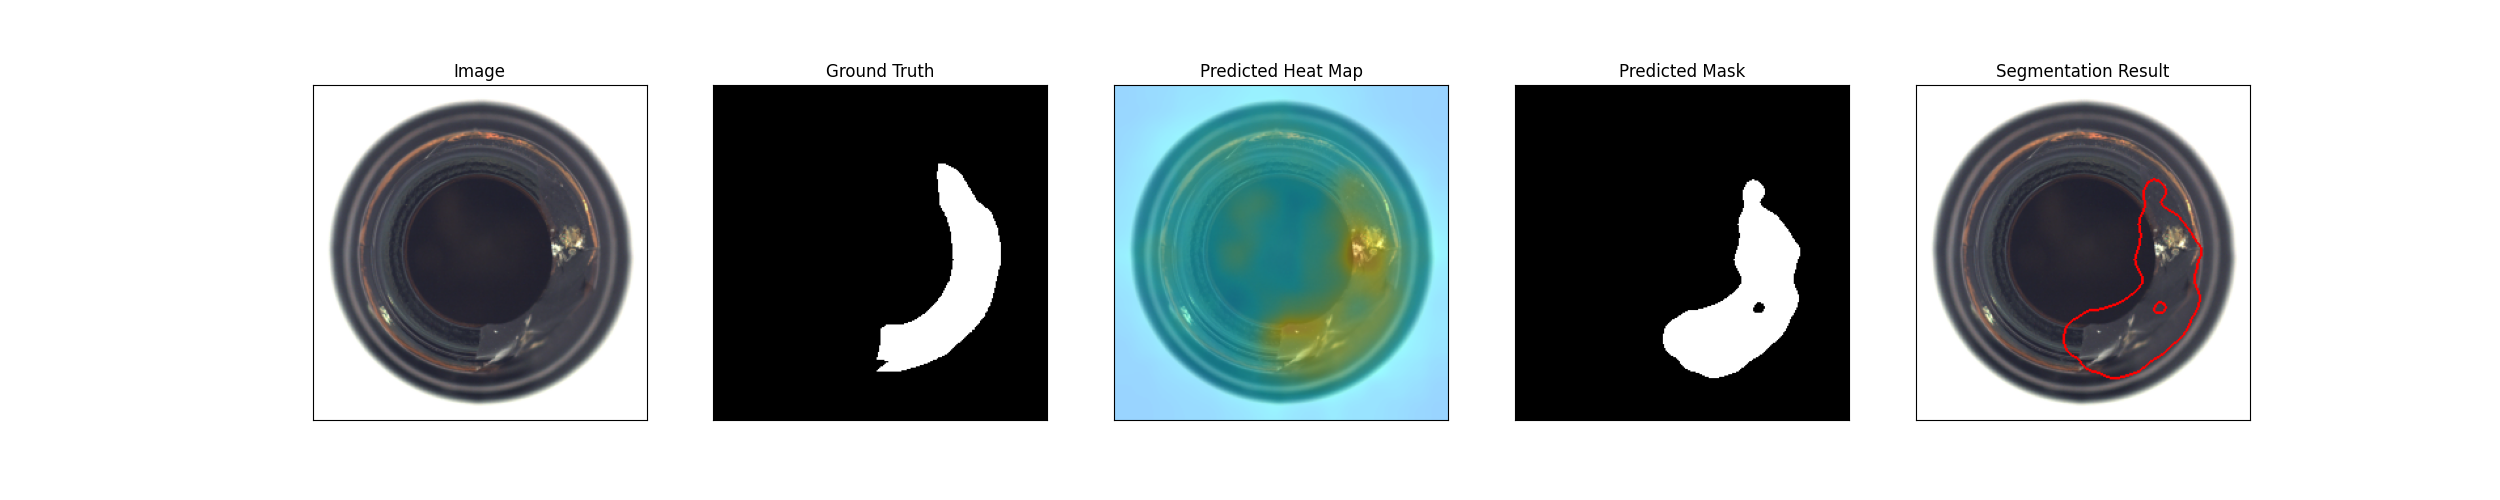

In [17]:
for filename in image_filenames[:10]:
    image = Image.open(filename)
    display(image)

## NNCF

DRAFT - WORK IN PROGRESS

In [18]:
import logging
import nncf
from nncf import NNCFConfig
from nncf.common.utils.logger import set_log_level
from nncf.torch import create_compressed_model, register_default_init_args

input_shape = list(data["image"].shape)
input_shape[0] = 1
set_log_level(logging.ERROR)  # Disables all NNCF info and warning messages
nncf_config_dict = {
    "input_info": {"sample_size": input_shape},
    "compression": {
        "algorithm": "quantization",
    },
    "range": {
        "num_init_samples": 300,
      }
}


config["project"]["path"] = "nncf_results/padim/mvtec/bottle"
model = get_model(config)

nncf_config = NNCFConfig.from_dict(nncf_config_dict)
nncf_loader = InitLoader(datamodule.train_dataloader())
nncf_config = register_default_init_args(nncf_config, nncf_loader)

compression_ctrl, compressed_model = create_compressed_model(
    model.model, nncf_config,  dump_graphs=False
)
model.model = compressed_model

callbacks = get_callbacks(config)
nncf_trainer = Trainer(**config.trainer, callbacks=callbacks)
nncf_trainer.fit(model=model, datamodule=datamodule)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/ubuntu/venvs/anomalib_env/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/ubuntu/repos/anomalib/notebooks/000_getting_started/nncf_results/padim/mvtec/bottle/weights exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name                  | Type     

Epoch 0:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7/10 [00:04<00:01,  1.70it/s, loss=nan, v_num=28]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it, loss=nan, v_num=28, pixel_F1Score=0.699, pixel_AUROC=0.973]


In [19]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=nncf_trainer.checkpoint_callback.best_model_path)

nncf_trainer.callbacks.insert(0, load_model_callback)
nncf_trainer.test(model=model, datamodule=datamodule)
int8_metrics = nncf_trainer.test(model=model, datamodule=datamodule)

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.73s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9944444298744202
      image_F1Score              0.984375
       pixel_AUROC          0.9729405045509338
      pixel_F1Score         0.6991304159164429
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<

In [20]:
fp32_metrics

[{'pixel_F1Score': 0.7229292988777161,
  'pixel_AUROC': 0.9824491143226624,
  'image_F1Score': 0.984375,
  'image_AUROC': 0.9928570985794067}]

In [21]:
int8_metrics

[{'pixel_F1Score': 0.6991304159164429,
  'pixel_AUROC': 0.9729405045509338,
  'image_F1Score': 0.984375,
  'image_AUROC': 0.9944444298744202}]

In [28]:
compression_ctrl.export_model("nncf_model.onnx", save_format="onnx_13")

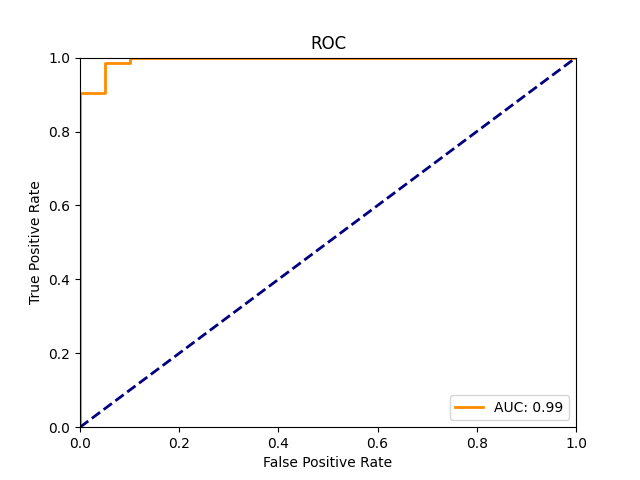

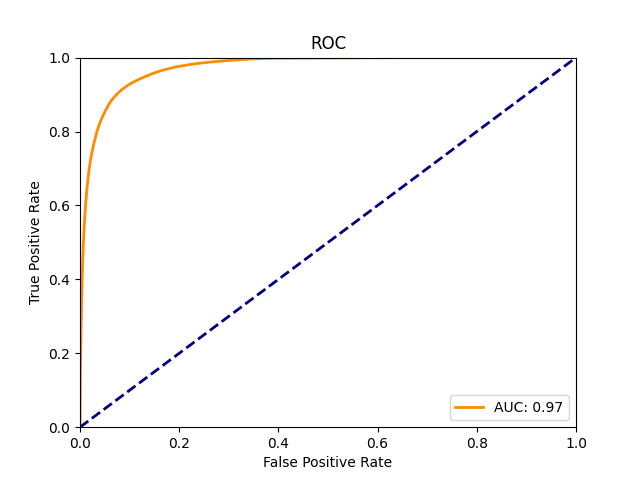

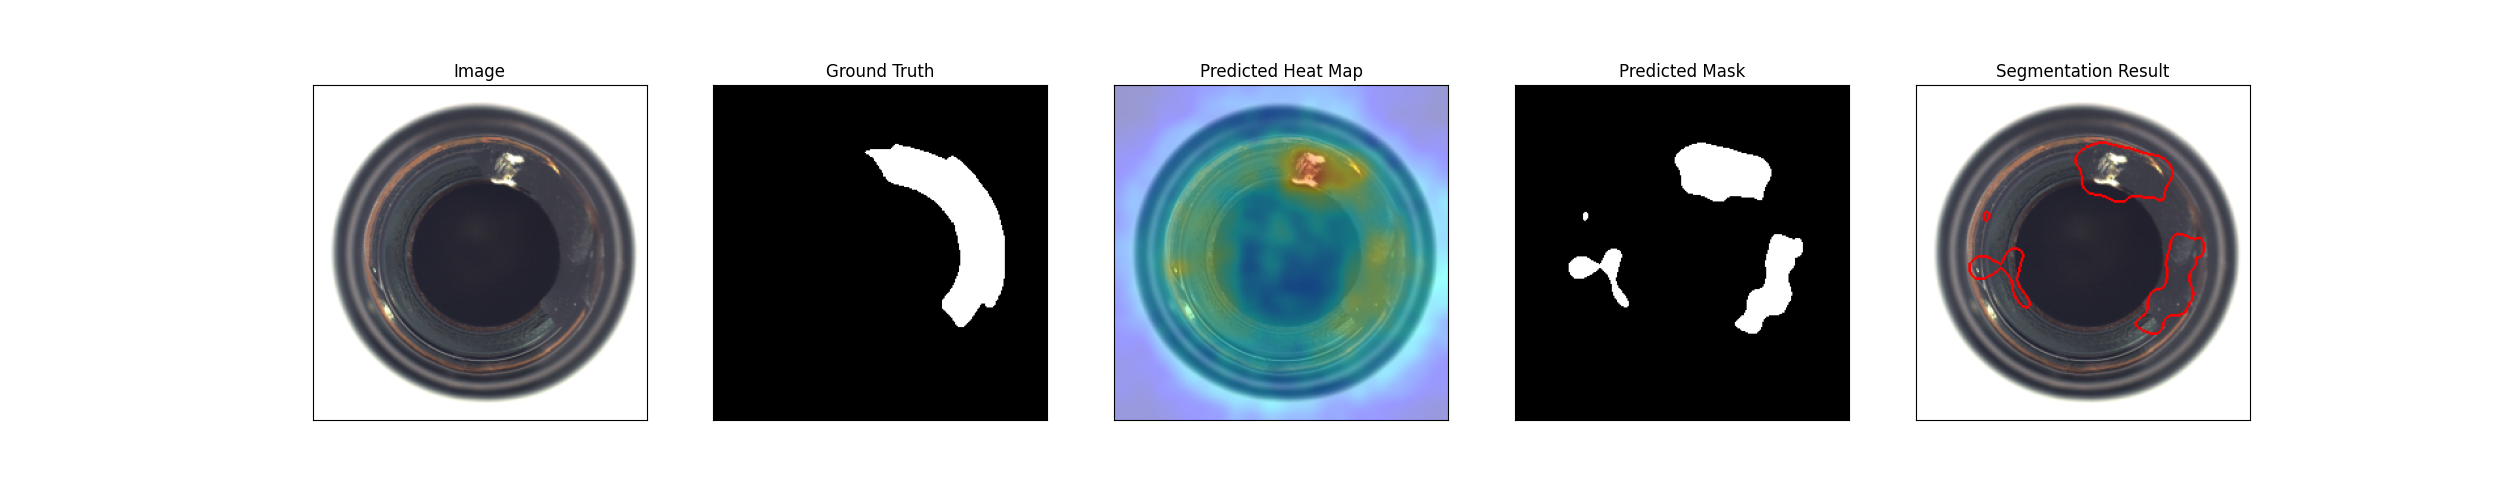

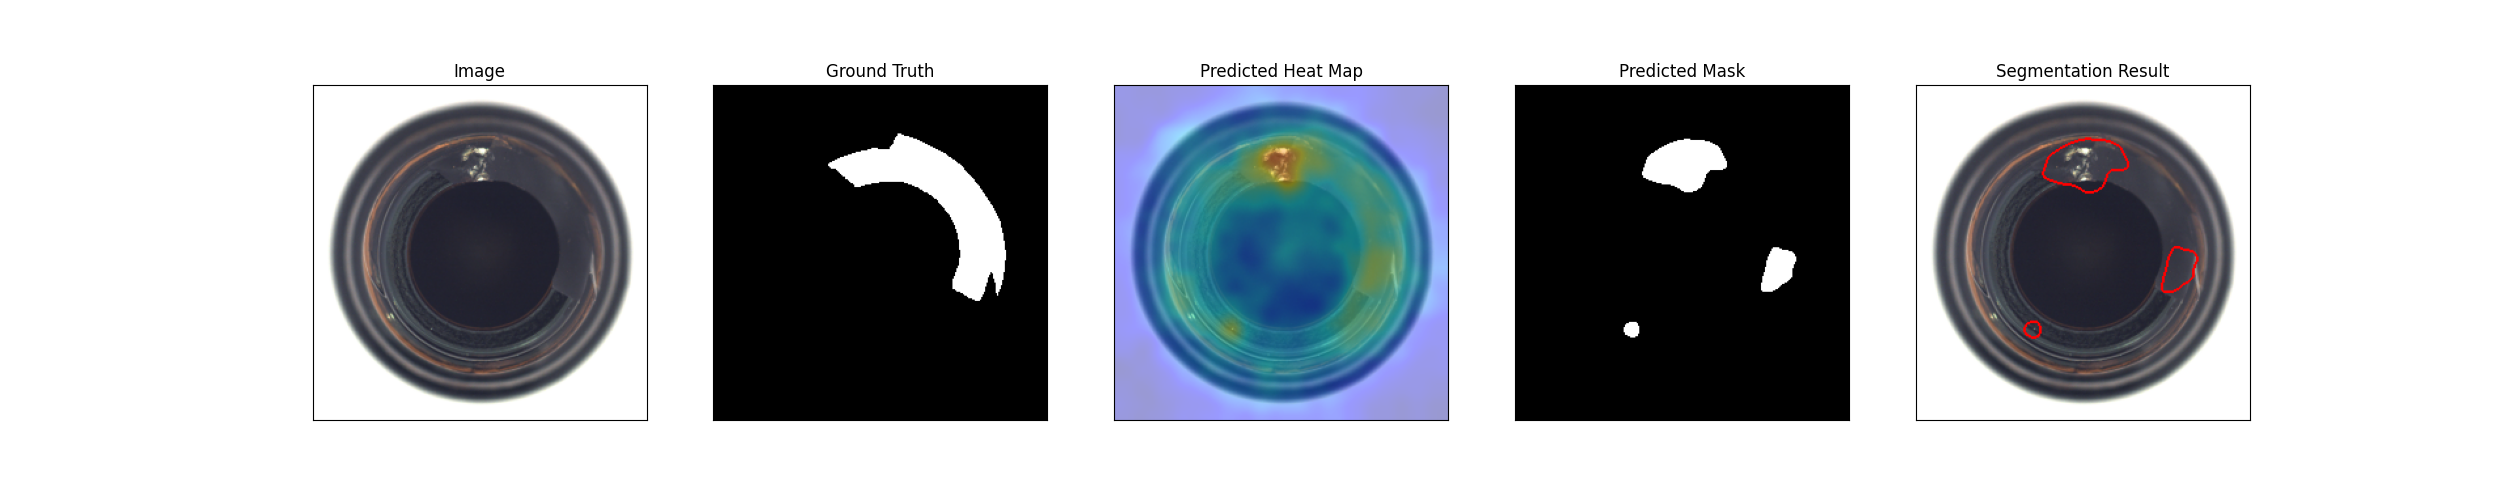

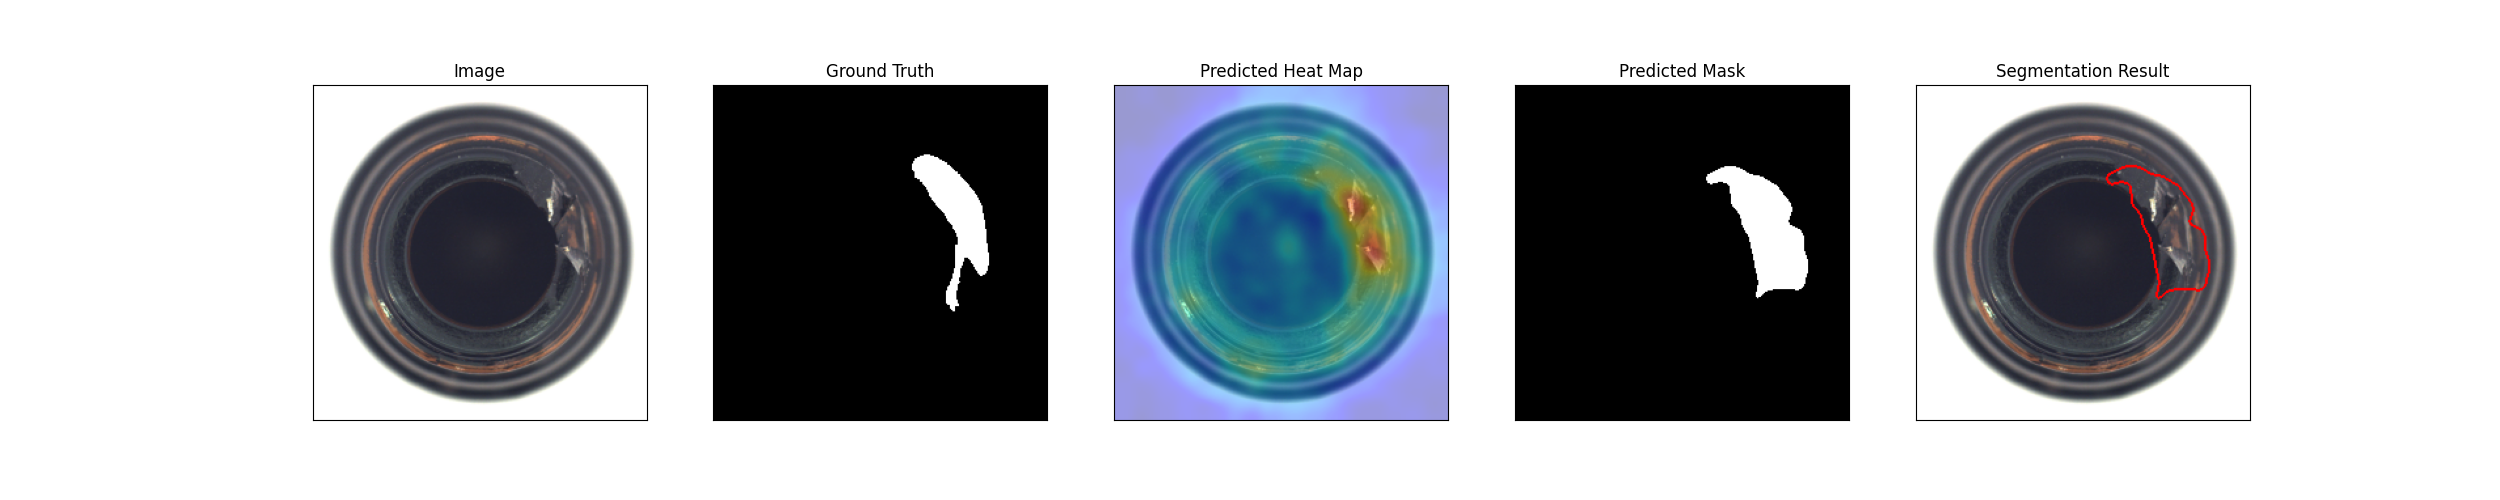

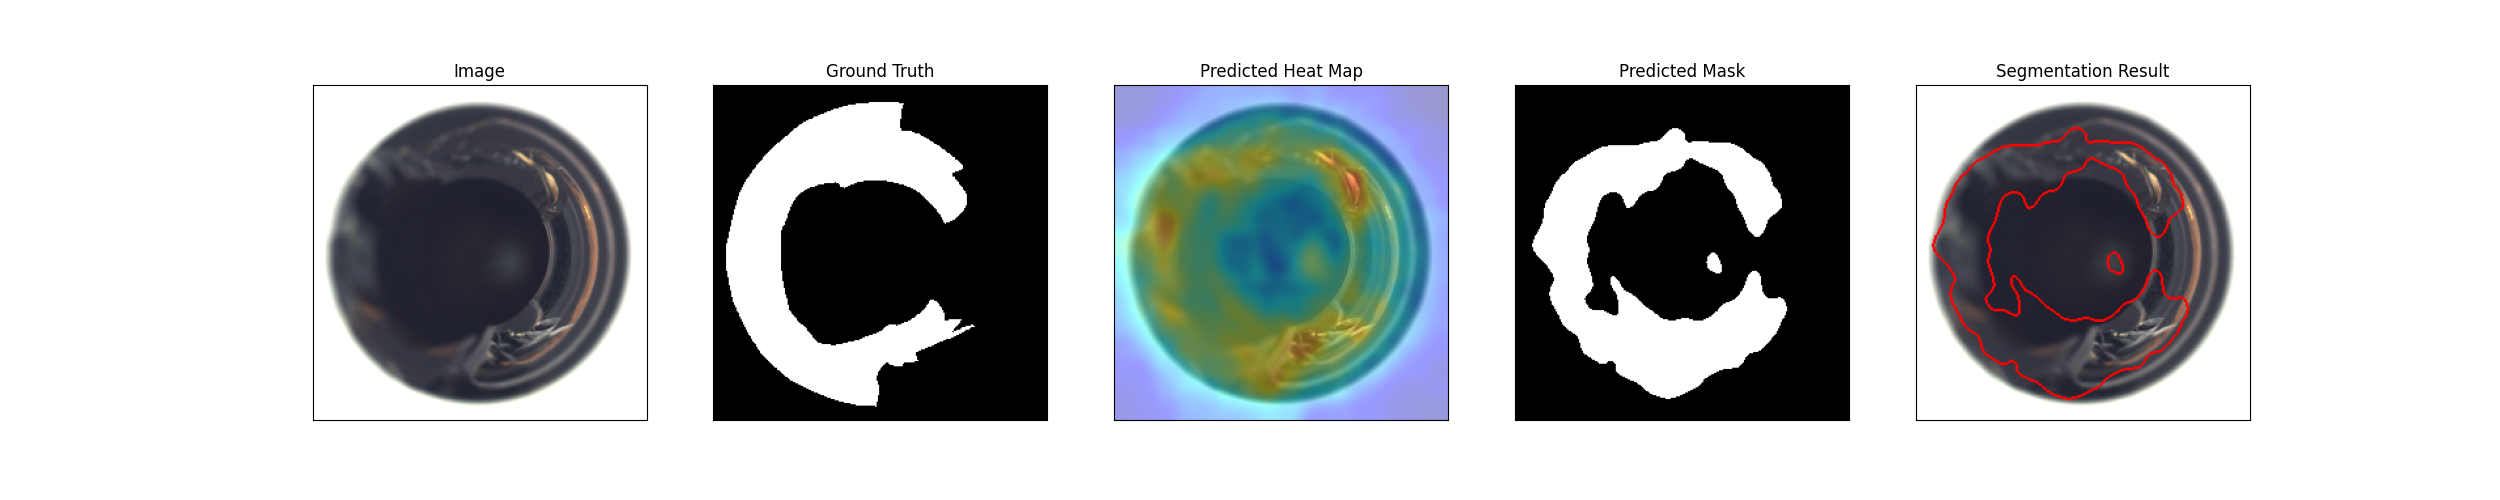

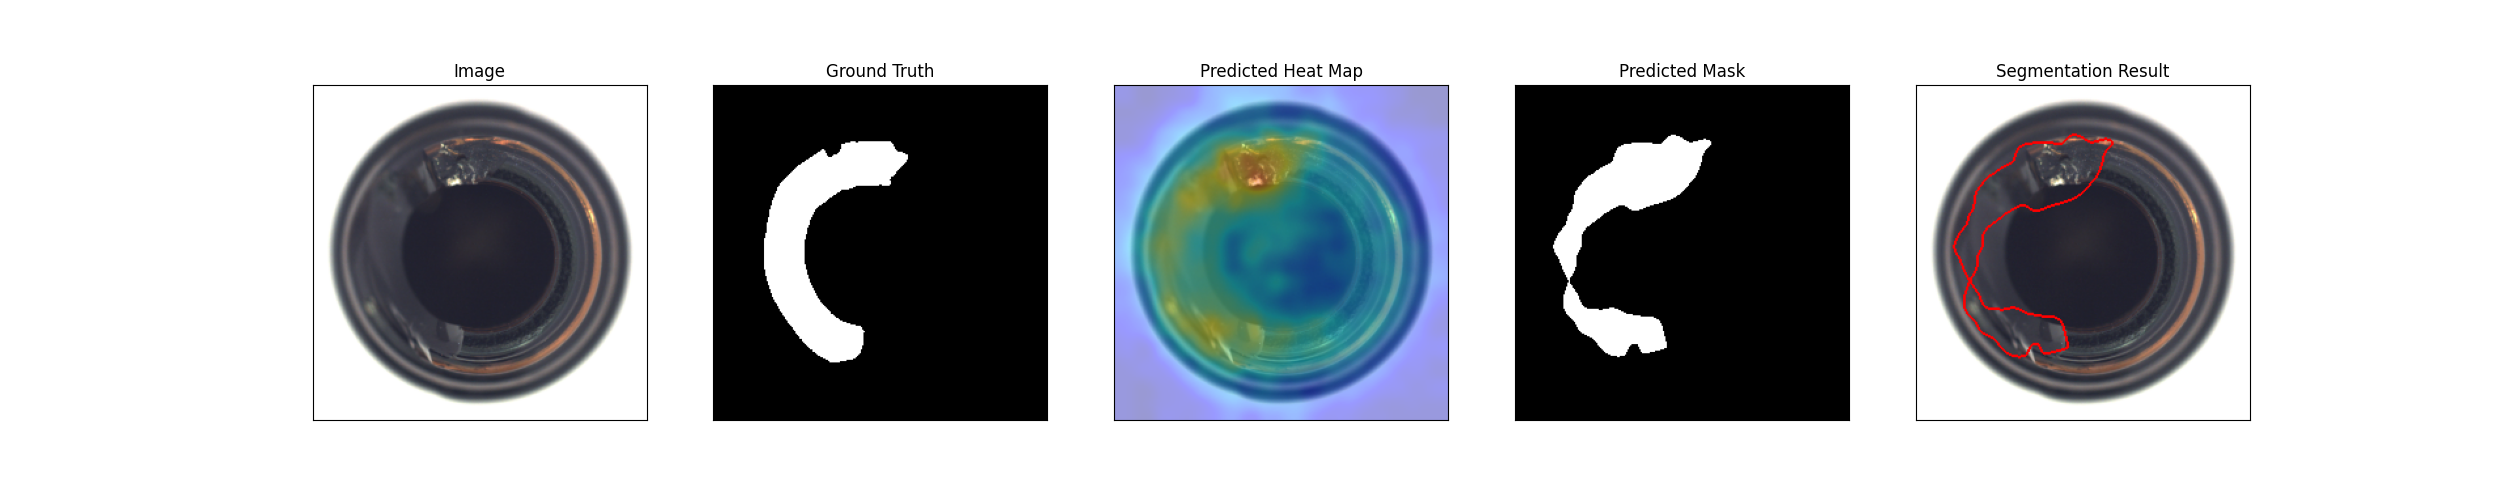

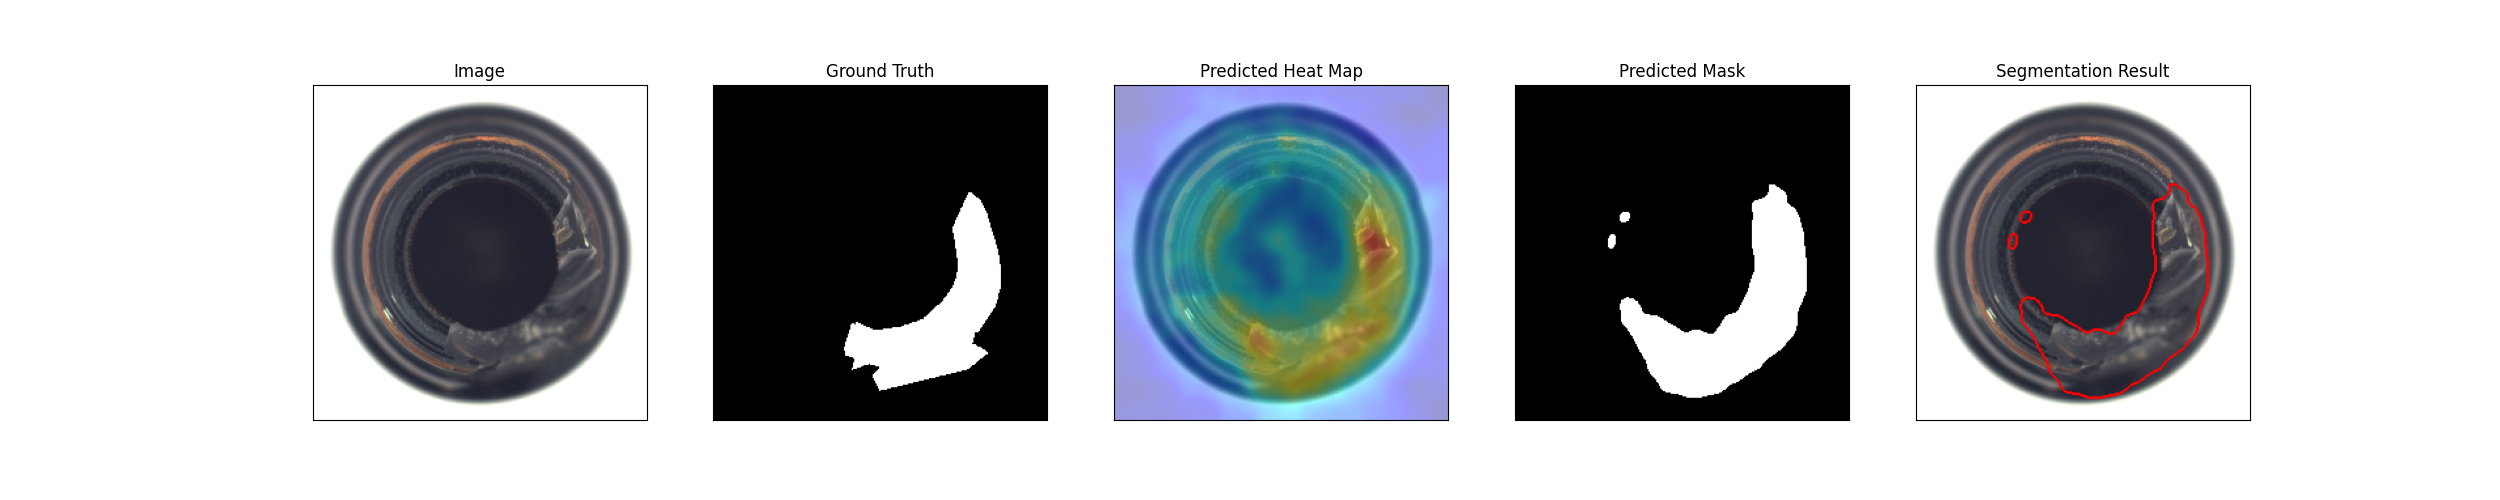

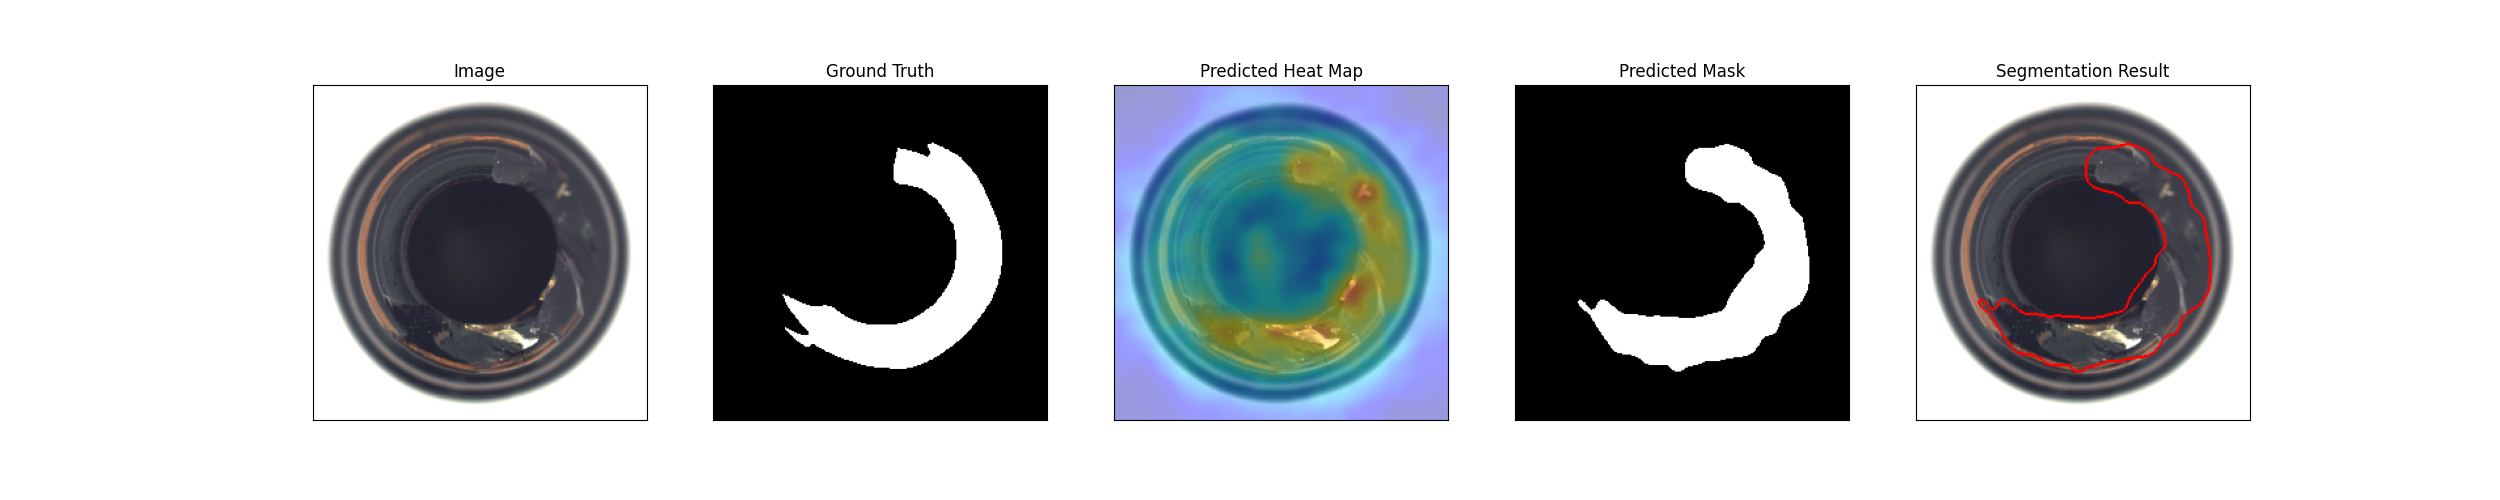

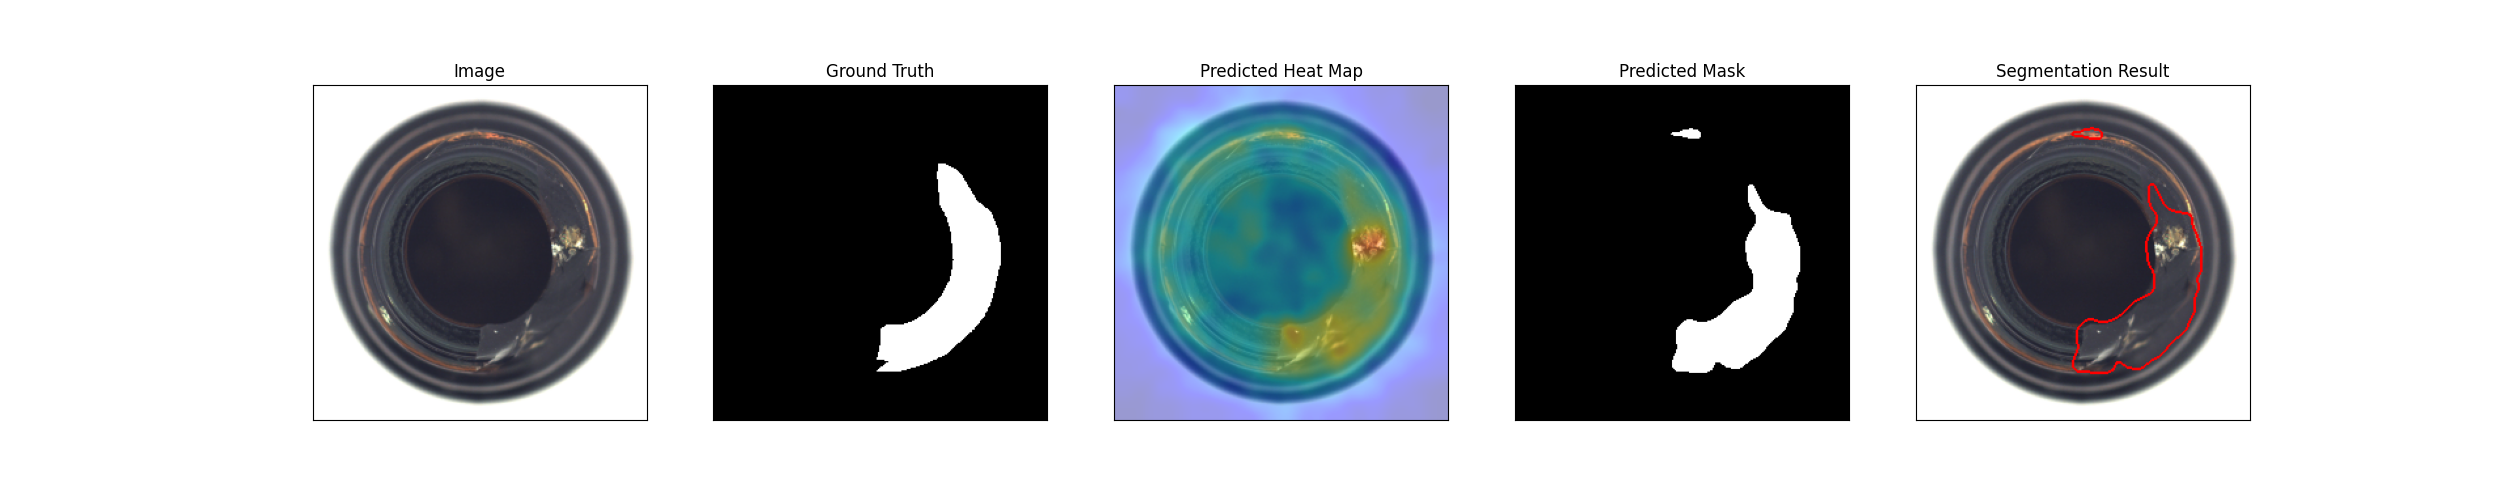

In [23]:
nncf_image_filenames = list(Path(config["project"]["path"]).glob("**/*.png"))

for int8_filename in nncf_image_filenames[:10]:
    image = Image.open(int8_filename)
    display(image)

In [34]:
!benchmark_app -m fp32_model.onnx -t 10 -shape [1,3,256,256]

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.2.0-7713-af16ea1d79a-releases/2022/2
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.2
         Build................... 2022.2.0-7713-af16ea1d79a-releases/2022/2

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] 

In [33]:
!benchmark_app -m nncf_model.onnx -t 10 -shape [1,3,256,256]

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.2.0-7713-af16ea1d79a-releases/2022/2
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.2
         Build................... 2022.2.0-7713-af16ea1d79a-releases/2022/2

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] 